In [146]:
import pandas as pd
import numpy as np
import datetime as dt
import os
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


import time

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

# Description of the Problem

Cryptocurrency has been all over the news lately. Bitcoin historical price and volume data from 2014 to Jan 2018, manipulated. We are classifying whether or not you should buy or sell Bitcoin. Given little information about bitcoin, Technical Analysis will be helpful. 

Describe EMA, bbp, etc. 

Training and Testing error. Training time. ROC curve



2. the training and testing error rates you obtained running the various learning algorithms on your problems. At the very least you should include graphs that show performance on both training and test data as a function of training size (note that this implies that you need to design a classification problem that has more than a trivial amount of data) and--for the algorithms that are iterative--training times/iterations. Both of these kinds of graphs are referred to as learning curves, BTW.

3. analyses of your results. Why did you get the results you did? Compare and contrast the different algorithms. What sort of changes might you make to each of those algorithms to improve performance? How fast were they in terms of wall clock time? Iterations? Would cross validation help (and if it would, why didn't you implement it?)? How much performance was due to the problems you chose? How about the values you chose for learning rates, stopping criteria, pruning methods, and so forth (and why doesn't your analysis show results for the different values you chose?)? Which algorithm performed best? How do you define best? Be creative and think of as many questions you can, and as many answers as you can.


-Why did you get the results you did? 

-Compare and contrast the different algorithms. 

-What sort of changes might you make to each of those algorithms to improve performance? 

-How fast were they in terms of wall clock time? Iterations? 

-Would cross validation help (and if it would, why didn't you implement it?)? How much performance was due to the 
problems you chose? 

-How about the values you chose for learning rates, stopping criteria, pruning methods, and so forth (and why doesn't your analysis show results for the different values you chose?)? 

-Which algorithm performed best? How do you define best? Be creative and think of as many questions you can, and as many answers as you can.


In descending order from the Upper Band:

%B Above 1 = Price is Above the Upper Band

%B Equal to 1 = Price is at the Upper Band

%B Above .50 = Price is Above the Middle Line

%B Below .50 = Price is Below the Middle Line

%B Equal to 0 = Price is at the Lower Band

%B Below 0 = Price is Below the Lower Band

Generally speaking .80 and .20 are also relevant levels.

%B Above .80 = Price is Nearing the Upper Band
%B Below .20 = Price is Nearing the Lower Band

In [131]:
df = pd.read_csv('BTCUSDKraken.csv', index_col=0, usecols=['Date','Volume (BTC)', 'Weighted Price'])
df = df.drop('2018-01-12')
df = df.replace([0], np.nan)
df = df.ffill(axis=None, inplace=False, limit=None, downcast=None)
lookback = 3

In [132]:
delta = df['Weighted Price'].diff()
dUp, dDown = delta.copy(), delta.copy()
dUp[dUp < 0] = 0
dDown[dDown > 0] = 0

RolUp = pd.rolling_mean(dUp, lookback)
RolDown = pd.rolling_mean(dDown, lookback).abs()

df['RSI'] = RolUp / RolDown

/Users/bryanbaek/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()
  
/Users/bryanbaek/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()
  import sys


In [133]:
sma = pd.rolling_mean(df['Weighted Price'], window = lookback, min_periods = lookback)
ema = pd.ewma(df['Weighted Price'], span = lookback, min_periods = lookback)
rolling_std = pd.rolling_std(df['Weighted Price'], window = lookback, min_periods = lookback)
up = (rolling_std * 2) + ema
down = (rolling_std * -2) + ema

/Users/bryanbaek/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=3,window=3,center=False).mean()
  """Entry point for launching an IPython kernel.
/Users/bryanbaek/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=3,min_periods=3,adjust=True).mean()
  
/Users/bryanbaek/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=3,window=3,center=False).std()
  This is separate from the ipykernel package so we can avoid doing imports until


In [134]:
#df['Price/SMA'] = df['Weighted Price']/sma
df['bbp'] = (df['Weighted Price'] - down) / (up - down)
df['Price/EMA'] = df['Weighted Price'] / ema
df['price_momentum'] = df['Weighted Price'].pct_change(periods = lookback - 1)
df['vol_momentum'] = df['Volume (BTC)'].pct_change(periods = lookback - 1)
df['bestaction'] = df['Weighted Price'].pct_change(periods = 1)

In [135]:
# suggestion_conditions = [
#     (df['Price/EMA'] < 0.97) & (df['bbp'] < 0.25),
#     (df['Price/EMA'] > 1.01) & (df['bbp'] > 0.75)]

actual_conditions = [
    (df['bestaction'] >= 0.04), 
    ( (0.04 > df['bestaction']) & (df['bestaction'] > 0) ),
    ( (0 > df['bestaction']) & (df['bestaction'] > -0.04) ),
    (df['bestaction'] <= -0.04) ]

choices = [2, 1, -1, -2]
#df['Suggestion'] = np.select(suggestion_conditions, choices, default=0)
df['Action'] = np.select(actual_conditions, choices, default=0)

In [136]:
df = df.drop(['Volume (BTC)', 'Weighted Price', 'bestaction'], axis=1)
df = df.drop(df.index[0:lookback])

In [137]:
df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how='any')

In [144]:
features = list(df.columns[0:-1])
X = df[features]
Y = df['Action']

#Shuffle = False b/c gotta train on earlier data and test on later data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)

# 1. Decision Tree

In [164]:

start = time.time()

DT = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=5, 
                                  min_samples_leaf=2, min_weight_fraction_leaf=0.0, max_features=None, 
                                  random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                  min_impurity_split=None, class_weight=None, presort=False)

#The least populated class in y has only 8 members, which is too few. 
#The minimum number of members in any class cannot be less than n_splits=9.
scores = cross_val_score(DT, X_train, Y_train, cv = 8)

print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

DT = DT.fit(X_train, Y_train)
Ypreds = DT.predict(X_test)

print accuracy_score(Y_test, Ypreds)

end=time.time()

print end-start

[ 0.72277228  0.75247525  0.66666667  0.70707071  0.74489796  0.64285714
  0.7755102   0.79381443]
Accuracy: 0.73 (+/- 0.10)
0.717948717949
0.0609700679779


Pruning:

min_samples_split : int, float, optional (default=2)
The minimum number of samples required to split an internal node

min_samples_leaf : int, float, optional (default=1)
The minimum number of samples required to be at a leaf node:

# 2. Neural Networks (Multi-layer Perceptron (MLP) )

Pro:
*Capability to learn non-linear models.

Con: 
*MLP with hidden layers have a non-convex loss function where there exists more than one local minimum. Therefore different random weight initializations can lead to different validation accuracy.

*MLP requires tuning a number of hyperparameters such as the number of hidden neurons, layers, and iterations.

*MLP is sensitive to feature scaling.


## Features:
1. hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)

The ith element represents the number of neurons in the ith hidden layer.
hidden_layer_sizes=(10, 2) : 10 hidden layer with 2 hidden units

2. activation : {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default ‘relu’
Activation function for the hidden layer.

3. solver : {‘lbfgs’, ‘sgd’, ‘adam’}, default ‘adam’
The solver for weight optimization.

4. learning_rate : {‘constant’, ‘invscaling’, ‘adaptive’}, default ‘constant’
Learning rate schedule for weight updates.

In [165]:
from sklearn.neural_network import MLPClassifier

start = time.time()


NN = MLPClassifier(hidden_layer_sizes=(20, 5), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', 
 learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, 
 random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, 
 early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

scores = cross_val_score(NN, X_train, Y_train, cv = 10)

print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

NN = NN.fit(X_train, Y_train)
Ypreds = NN.predict(X_test)

print accuracy_score(Y_test, Ypreds)


end=time.time()

print end-start

[ 0.65853659  0.51219512  0.425       0.475       0.37974684  0.48717949
  0.52564103  0.32051282  0.46753247  0.48051948]
Accuracy: 0.47 (+/- 0.17)
0.405128205128
2.18549799919


# 3. Boosting (AdaBoost on Decision Trees)



## Features:

1. n_estimators : integer, optional (default=10)
The number of trees in the forest.

2. criterion : string, optional (default=”gini”)
The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

3. max_features : int, float, string or None, optional (default=”auto”)
The number of features to consider when looking for the best split:

4. max_depth : integer or None, optional (default=None)
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

5. min_samples_split : int, float, optional (default=2)
The minimum number of samples required to split an internal node

6. min_samples_leaf : int, float, optional (default=1)
The minimum number of samples required to be at a leaf node

In [166]:
from sklearn.ensemble import AdaBoostClassifier

start = time.time()

Boost = AdaBoostClassifier(
    tree.DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1)

#RF = RF.fit(X_train, Y_train) 
#Ypreds = RF.predict(X_test)

scores = cross_val_score(Boost, X_train, Y_train, cv = 10)

print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Boost = Boost.fit(X_train, Y_train)
Ypreds = Boost.predict(X_test)

print accuracy_score(Y_test, Ypreds)


end=time.time()

print end-start

[ 0.7804878   0.75609756  0.7         0.7         0.72151899  0.73076923
  0.61538462  0.6025641   0.77922078  0.76623377]
Accuracy: 0.72 (+/- 0.12)
0.712820512821
25.5059781075


# 4. SVM

-at least 2 kernel functions

Pros: 
* Effective in high dimensional spaces.
* Still effective in cases where number of dimensions is greater than the number of samples.
* Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
* Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

Cons:

* If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.
* SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation

## Features:

1. Kernel(Linear, RBF, poly, sigmoid, precomputed)

Linear kernel = Straight Line (hyperplane) as the decision boundary
* rarely used in practice

Radial Basis Function (RBF) = commonly used kernel in SVC
2 parameters:
* gamma
* C

2. Gamma:
*  'spread' of the kernel and therefore the decision region.
* low gamma -> the 'curve' of the decision boundary is very low and thus the decision region is very broad (underfitting)
* gamma = 10 (The decision boundary starts to be highly effected by individual data points (i.e. variance)).
* high gamma -> the 'curve' of the decision boundary is high, which creates islands of decision-boundaries around data points (overfitting)
* If gamma is ‘auto’ then 1/n_features will be used instead.
* gamma defines how much influence a single training example has. 
* The larger gamma is, the closer other examples must be to be affected.

3. C:
* trades off misclassification of training examples against simplicity of the decision surface
* A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly
* penalty for misclassifying a data point
* small C -> classifier is okay with misclassified data points (high bias, low variance)
* big C -> classifier is heavily penalized for misclassified data and therefore bends over backwards avoid any misclassified data points (low bias, high variance)

C > 10 is too slow

4. degree : int, optional (default=3)
* Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.

In [168]:
from sklearn.svm import SVC

start = time.time()

SVM = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
          decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
          max_iter=-1, probability=False, random_state=None, shrinking=True,
          tol=0.001, verbose=False)
#SVM.fit(X_train, Y_train) 
scores = cross_val_score(SVM, X_train, Y_train, cv = 10)

#print ("Kernel: %s | Gamma: %0.2f | C: %i" % (i, C, D))
#print ("Kernel: %s" % (i))
print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


SVM = SVM.fit(X_train, Y_train)
Ypreds = SVM.predict(X_test)

print accuracy_score(Y_test, Ypreds)



end=time.time()

print end-start

[ 0.57317073  0.6097561   0.525       0.5625      0.56962025  0.58974359
  0.70512821  0.52564103  0.64935065  0.5974026 ]
Accuracy: 0.59 (+/- 0.10)
0.584615384615
0.253733873367


# 5. KNN

In [169]:
from sklearn.neighbors import KNeighborsClassifier


start = time.time()

KNN = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', 
                           leaf_size=30, p=2, metric='minkowski', metric_params=None, 
                           n_jobs=1)
#KNN.fit(X_train, Y_train)
scores = cross_val_score(KNN, X_train, Y_train, cv = 10)

print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

KNN = KNN.fit(X_train, Y_train)
Ypreds = KNN.predict(X_test)

print accuracy_score(Y_test, Ypreds)

end=time.time()

print end-start

[ 0.54878049  0.59756098  0.4375      0.525       0.58227848  0.6025641
  0.65384615  0.52564103  0.5974026   0.55844156]
Accuracy: 0.56 (+/- 0.11)
0.538461538462
0.0543849468231


## Features:

1. weights : str or callable, optional (default = ‘uniform’)
weight function used in prediction. Possible values:


* uniform : uniform weights. All points in each neighborhood are weighted equally.

* distance : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.

## II. Model Comparison

## 1. ROC Curves

In [ ]:
ROC curve

In [145]:
names = ["Decision Tree", "Neural Network", "AdaBoost", "SVM", "KNN"]

#implement ROC Curves

h = .02 

classifiers = [DT, NN, Boost, SVM, KNN]

In [173]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  6  35   3   0]
 [  5 117  35   1]
 [  0  49  85   6]
 [  0  16  30   2]]
Normalized confusion matrix
[[ 0.14  0.8   0.07  0.  ]
 [ 0.03  0.74  0.22  0.01]
 [ 0.    0.35  0.61  0.04]
 [ 0.    0.33  0.62  0.04]]


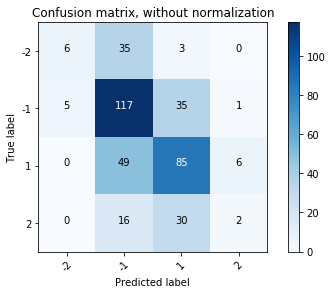

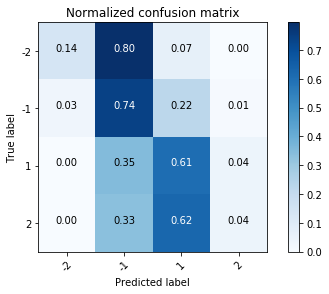

In [182]:
cnf_matrix = confusion_matrix(Y_test, Ypreds)
np.set_printoptions(precision=2)

class_names = [-2, -1, 1, 2]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [185]:
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

n_classes = 4


start=time.time()
# Learn to predict each class against the other
classifier = OneVsRestClassifier(SVC(kernel='linear', probability=True))
y_score = classifier.fit(X_train, Y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


end=time.time()
print (end-start)

ValueError: Can only tuple-index with a MultiIndex

In [188]:
fpr, tpr, thresholds = roc_curve(Y_test, Ypreds, pos_label=2)

In [190]:
auc(fpr, tpr)

0.64973196881091622

In [194]:
#from sklearn.learning_curve import learning_curve
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



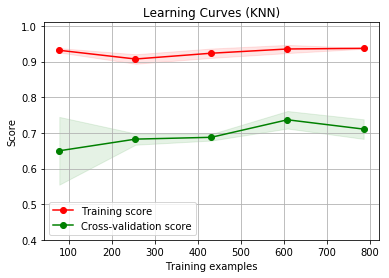

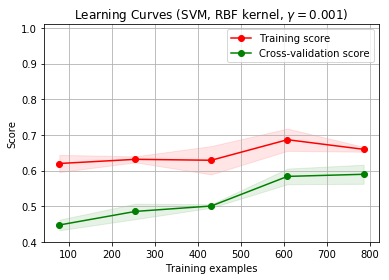

In [198]:
title = "Learning Curves (KNN)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.

plot_learning_curve(DT, title, X, Y, ylim=(0.4, 1.01), n_jobs=4)

title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
plot_learning_curve(SVM, title, X, Y, (0.4, 1.01), n_jobs=4)

plt.show()
